In [3]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import tsam.timeseriesaggregation as tsam
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 

from pypsa.descriptors import (
    Dict,
    additional_linkports,
    expand_series,
    get_active_assets,
    get_activity_mask,
    get_bounds_pu,
    get_extendable_i,
    get_non_extendable_i,
    nominal_attrs,
)

%run ../scripts/_helpers.py

In [2]:
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.style.use('Meridian.mplstyle')

In [3]:
colour_map={'wind':'#77D1E4',
            'wind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'solar_csp':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'phs':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'hydro_import':'#004F95',
            'other':'#004F95',
            'ocgt':'#8D7867',
            'ocgt_diesel':'#8D7867',
            'ocgt_gas':'#8D7867',
            'ccgt_gas':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [4]:
n={}

In [5]:
# Load PyPSA networks from results folder

n['LC_UNC'] = pypsa.Network('../networks/solved_val-LC-UNC_1-supply_redz_lcopt_LC.nc')
#n['LC_SMOOTH'] = pypsa.Network('../results/networks/solved_val-LC-SMOOTH_RSA_redz_lcopt_LC.nc')
#n['LC_UNC-2000SEG'] = pypsa.Network('../results/networks/solved_val-LC-UNC_RSA_redz_lcopt_LC-2000SEG.nc')
#n['2Gt_UNC'] = pypsa.Network('../results/networks/solved_val-2Gt-UNC_RSA_redz_lcopt_Co2L.nc')
#n['2Gt_SMOOTH'] = pypsa.Network('../results/networks/solved_val-2Gt-SMOOTH_RSA_redz_lcopt_Co2L.nc')

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/home/pklein/anaconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/geopandas/geoseries.py:207: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in

In [6]:
# Generate a DataFrame for the capacity and energy
scenario ='LC_SMOOTH'
seg=""
capacity = aggregate_capacity(n[scenario+seg])/1000
energy = aggregate_energy(n[scenario+seg])/1e6

capacity.loc['hydro',:] = capacity.loc['hydro',:]+capacity.loc['hydro_import',:]
capacity2.loc['hydro',:] = capacity2.loc['hydro',:]+capacity2.loc['hydro_import',:]
energy.loc['hydro',:] = energy.loc['hydro',:]+energy.loc['hydro_import',:]
energy2.loc['hydro',:] = energy2.loc['hydro',:]+energy2.loc['hydro_import',:]

capacity.loc['other',:]= capacity.loc['hydro',:]+capacity.loc['biomass',:]
energy.loc['other',:] = energy.loc['hydro',:]+energy.loc['biomass',:]

capacity = capacity.drop(['load_shedding','hydro_import'])
capacity2 = capacity2.drop(['load_shedding','hydro_import'])
energy = energy.drop(['load_shedding','hydro_import'])
energy2 = energy2.drop(['load_shedding','hydro_import'])

ambitions_capacity = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'capacity_CSIR_'+scenario,
    index_col=0
)/1000

ambitions_energy = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'energy_CSIR_'+scenario,
    index_col=0
)/1000
ambitions_capacity['other'] = ambitions_capacity['hydro'] + ambitions_capacity['biomass']
ambitions_energy['other'] = ambitions_energy['hydro'] + ambitions_energy['biomass']

KeyError: 'ccgt_gas'

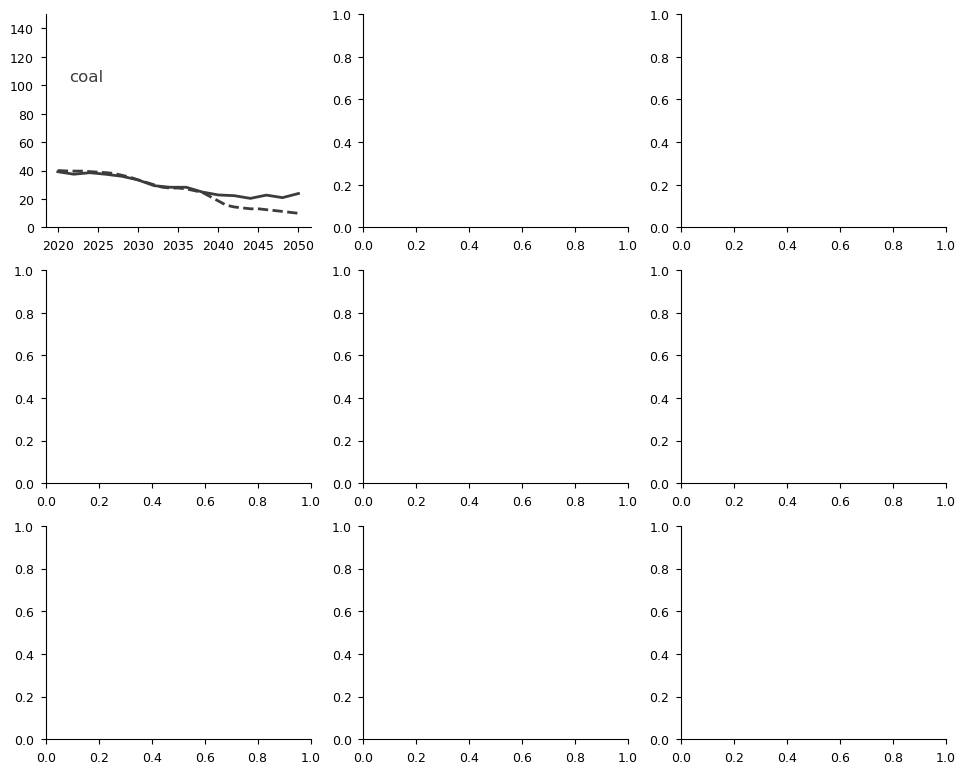

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 80
linewidth=2

technologies = ['coal', 'ccgt_gas', 'ocgt', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords = {
                'coal':TL_img,
                'ccgt_gas':TL_img,
                'ocgt':TL_img,
                'wind':TL_img,
                'solar_pv':TL_img,
                'solar_csp':TL_img,
                'battery':TL_img,
                'phs':TL_img,
                'other':TL_img,
}
txt_coords = {
                'coal':TL_txt,
                'ccgt_gas':TL_txt,
                'ocgt':TL_txt,
                'wind':TL_txt,
                'solar_pv':TL_txt,
                'solar_csp':TL_txt,
                'battery':TL_txt,
                'phs':TL_txt,
                'other':TL_txt,
}

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    #img = mpimg.imread('../../icons/'+tech+'.png')
    capacity.loc[tech,:].plot(kind='line', ax=axs[row, col], ylim=([0,y_max]), color=colour_map[tech], linewidth=linewidth)
    #capacity2.loc[tech,:].plot(kind='line', ax=axs[row, col], ylim=([0,y_max]), color='r', linestyle='--', linewidth=linewidth)
    ambitions_capacity[tech].plot(kind='line', ax=axs[row, col], xlabel='', color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    #imagebox = OffsetImage(img, zoom=0.07)
    #ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    #ax.add_artist(ab)
    annotation=ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

    annotation.set_fontfamily('sans-serif')

fig. suptitle("Capacity in GW", fontsize=15, y=0.93)
fig.savefig('line_capacity_'+scenario, dpi=150, bbox_inches='tight')

In [ ]:
n[scenario].generators.p_nom_opt[n[scenario].generators.carrier=='wind']

Generator
RSA-wind_BW1      807.400000
RSA-wind_BW2      562.500000
RSA-wind_BW3      774.100000
RSA-wind_BW4     1330.080000
RSA-wind_BW5     1636.700000
RSA-wind_BW6     1850.900000
RSA-wind-2022    1190.792464
RSA-wind-2024    1594.854638
RSA-wind-2026    2761.481437
RSA-wind-2028    1690.071682
RSA-wind-2030    1204.481232
RSA-wind-2032    6067.601022
RSA-wind-2034     832.072099
RSA-wind-2036    3902.539767
RSA-wind-2038    4176.571785
RSA-wind-2040      55.074524
RSA-wind-2042    3136.228667
RSA-wind-2044    3995.748505
RSA-wind-2046    5971.716239
RSA-wind-2048    7891.741457
RSA-wind-2050    1072.675574
Name: p_nom_opt, dtype: float64

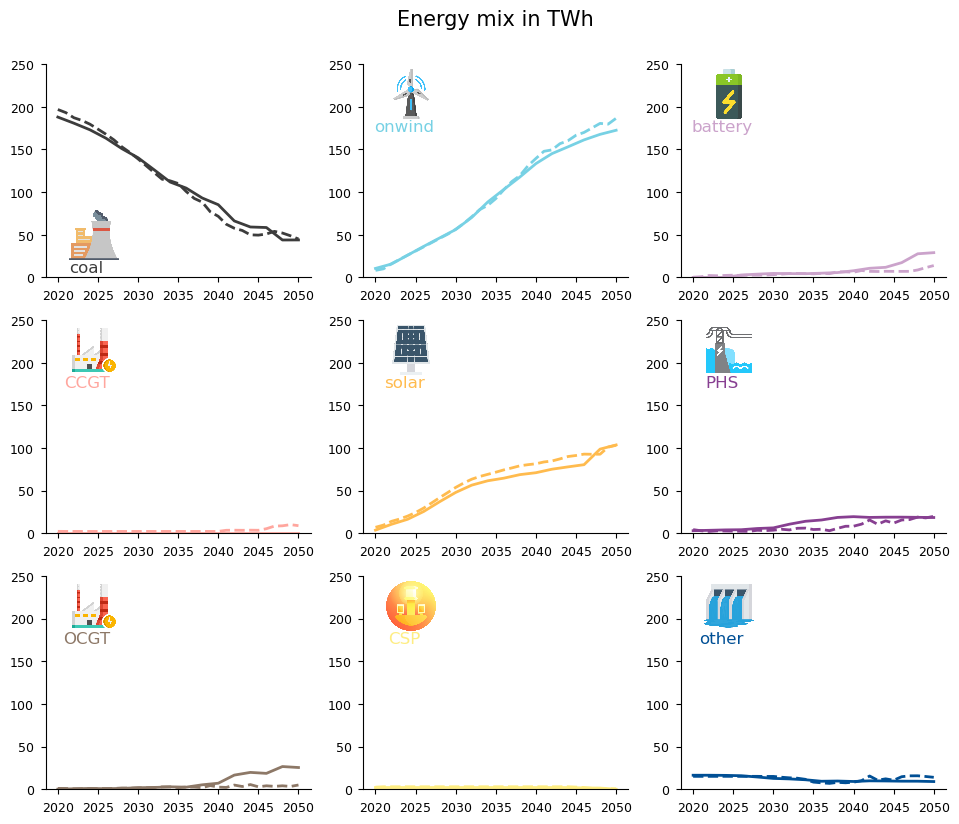

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 250
linewidth=2

technologies = ['coal', 'CCGT', 'OCGT', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords['coal'] = BL_img
txt_coords['coal'] = BL_txt

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    img = mpimg.imread('../../icons/'+tech+'.png')
    energy.loc[tech,:].plot(kind='line', ax=ax, color=colour_map[tech], linewidth=linewidth)
    ambitions_energy[tech].plot(kind='line', ax=ax, color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    ax.set_ylim([0,y_max])
    ax.set_xlabel('')

    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    imagebox = OffsetImage(img, zoom=0.07)
    ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)
    ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

fig. suptitle("Energy mix in TWh", fontsize=15, y=0.93)
fig.savefig('line_energy_'+scenario, dpi=150, bbox_inches='tight')

In [ ]:
legend_adjustments = {
    'nuclear':0,
    'coal':5,
    'CCGT':7,
    'OCGT':0,
    'hydro':-5,
    'PHS':0,
    'biomass':5,
    'solar':0,
    'CSP':0,
    'onwind':0,
    'battery':0
}

In [ ]:
case ='pypsa'
plt.clf()
if case =='pypsa':
    plt_capacity = capacity
else:
    plt_capacity = ambitions_capacity.T
plt_capacity = plt_capacity.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = plt_capacity.T.plot.bar(figsize=(7, 6),stacked=True,color=colour_map,width=0.8,zorder=2)
plt.grid(axis='y', color='darkgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only

plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,220])
plt.yticks(range(0, 220+1, 20))  # set y-axis ticks to increments of 20
ax.yaxis.set_tick_params(which='both',length=0)

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# cnt=0
# height = 0     
# dy = 0  # adjust this value to fine-tune the vertical spacing between annotations
# for bar in ax.containers:
#     end_capacity = (plt_capacity).iloc[cnt,-1]
#     x = len(plt_capacity.T)-1
#     y = end_capacity/2+height+dy*cnt  # adjust y position based on index of the bar
#     ax.annotate(
#         plt_capacity.index[cnt],
#         xy=(x, y+legend_adjustments[plt_capacity.index[cnt]]),
#         xytext=(5, 0),
#         textcoords="offset points",
#         va="center",
#         color=ax.containers[cnt][-1].get_facecolor(),
#         #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
#     )
#     height += end_capacity
#     cnt+=1

handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(True)
ax.legend(handles[::-1], labels[::-1],handlelength=0.5, bbox_to_anchor=(1.0, 0), loc='lower left', borderaxespad=0.,frameon=False)
plt.savefig('capacity_'+scenario+'_'+case, dpi=150, bbox_inches='tight')

NameError: name 'plt' is not defined

<Figure size 669.291x437.008 with 0 Axes>

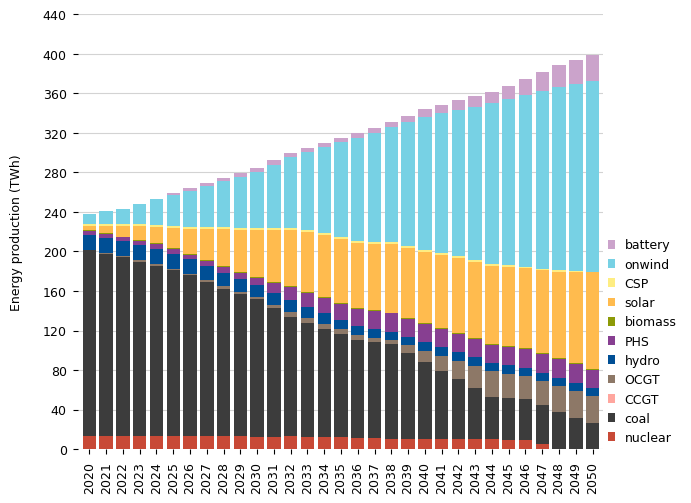

In [ ]:
case ='pypsa'
plt.clf()
if case =='pypsa':
    plt_energy = energy
else:
    plt_energy = ambitions_energy.T

plt_energy = plt_energy.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = plt_energy.T.plot.bar(figsize=(7,6),stacked=True,color=colour_map,width=0.8,zorder=2)
ax.grid(axis='y', color='lightgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only
plt.ylabel('Energy production (TWh)')
plt.xlabel("")
plt.yticks(range(0, 440+1, 40))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# cnt=0
# height = 0     
# dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
# for bar in ax.containers:
#     end_energy = (energy).iloc[cnt,-1]
#     x = len(energy.T)-1
#     y = end_energy/2+height+dy*cnt  # adjust y position based on index of the bar
#     ax.annotate(
#         energy.index[cnt],
#         xy=(x, y),
#         xytext=(5, 0),
#         textcoords="offset points",
#         va="center",
#         color=ax.containers[cnt][-1].get_facecolor(),
#         #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
#     )
#     height += end_energy
#     cnt+=1

handles, labels = ax.get_legend_handles_labels()
ax.legend().set_visible(True)
ax.legend(handles[::-1], labels[::-1],handlelength=0.5, bbox_to_anchor=(1.0, 0), loc='lower left', borderaxespad=0.,frameon=False)

plt.savefig('energy_'+scenario+'_'+case, dpi=150, bbox_inches='tight')


In [ ]:
n

{'2Gt_UNC': PyPSA Network 'PyPSA-ZA'
 Components:
  - Bus: 1
  - Carrier: 13
  - Generator: 176
  - GlobalConstraint: 257
  - Load: 1
  - StorageUnit: 36
 Snapshots: 140160,
 '2Gt_UNC-2000SEG': PyPSA Network 'PyPSA-ZA'
 Components:
  - Bus: 1
  - Carrier: 12
  - Generator: 176
  - GlobalConstraint: 257
  - Load: 1
  - StorageUnit: 36
 Snapshots: 32000,
 'LC_UNC': PyPSA Network 'PyPSA-ZA'
 Components:
  - Bus: 1
  - Carrier: 13
  - Generator: 176
  - GlobalConstraint: 256
  - Load: 1
  - StorageUnit: 36
 Snapshots: 140160,
 'LC_UNC-2000SEG': PyPSA Network 'PyPSA-ZA'
 Components:
  - Bus: 1
  - Carrier: 12
  - Generator: 176
  - GlobalConstraint: 256
  - Load: 1
  - StorageUnit: 36
 Snapshots: 32000}

In [ ]:
period_weighting = n[scenario].investment_period_weightings["years"]
weightings = n[scenario].snapshot_weightings.mul(period_weighting, level=0, axis=0).loc[
    n[scenario].snapshots
]
em_pu = n[scenario].generators.carrier.map(n[scenario].carriers.co2_emissions)
em_pu = (
    weightings["generators"].to_frame("weightings")
    @ em_pu.to_frame("weightings").T
)
emissions = em_pu.mul(n[scenario].generators_t.p/n[scenario].generators.efficiency).groupby(n[scenario].generators_t.p.index.get_level_values(0)).sum().sum(axis=1)
emissions

period
2020    4.521061e+08
2022    4.336779e+08
2024    4.126649e+08
2026    3.877202e+08
2028    3.553201e+08
2030    3.309807e+08
2032    2.880996e+08
2034    2.608068e+08
2036    2.361337e+08
2038    2.248025e+08
2040    1.862780e+08
2042    1.538017e+08
2044    1.195625e+08
2046    1.136982e+08
2048    1.099091e+08
2050    2.141678e+08
dtype: float64

In [ ]:
emissions.sum()/1e6

2200.000051572574

In [ ]:
emissions.sum()/1e9

1.999999705962403

In [ ]:
ambitions_energy['coal'].sum()/0.299*0.3

1915.3119269297658

In [ ]:
ambitions_energy['CCGT'].sum()/0.299*0.179

48.102343143605346

In [ ]:
ambitions_energy['OCGT'].sum()/0.299*0.179

37.553282686596354

In [ ]:
float(str('2.2'))*10


22.0